# Import Modules

In [1]:
from os import listdir
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint

# Reading Data

In [3]:
classes_dir = sorted(listdir("data/Kather_texture_2016_image_tiles_5000"))
classes_dir.remove('.DS_Store')
classes_dir

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [4]:
# for c in classes_dir:
# 	files = listdir(f'data/Kather_texture_2016_image_tiles_5000/{c}')
# 	for f in files:
# 		print(f'{c}: {f}')

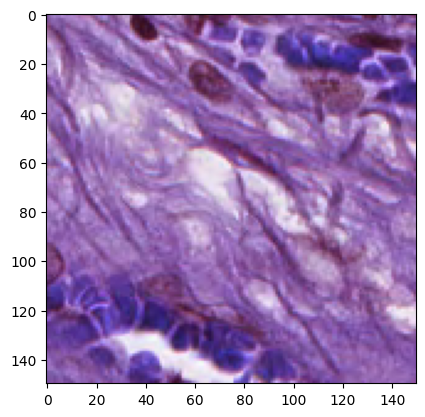

In [ ]:
img = cv2.imread('data/Kather_texture_2016_image_tiles_5000/01_TUMOR/89F4_CRC-Prim-HE-09_022.tif_Row_1_Col_1.tif')
plt.imshow(img)

In [6]:
# tf.debugging.set_log_device_placement(True)

when splitting the variable name into '01' and 'tumor', than when doing the hotencoding, the tumor will not be class 0. Because the hotencoding will sort the value alphabetically. Therefore it is easier to pass the variable name as "01_tumor", so will the hot encoding have class 0 as tumor.

In [7]:
with tf.device('/CPU:0'): # running on CPU
	start = datetime.now()
	data = []
	labels_string = []
	path = 'data/Kather_texture_2016_image_tiles_5000'
	for c in classes_dir:
		files = listdir(f'{path}/{c}')
		for f in files:
			# l = c.split('_')[1].lower() # to pass only name of class without numbering.
			labels_string.append(c)
			img = load_img(f'{path}/{c}/{f}', target_size=(128, 128))
			img = img_to_array(img)
			# img = preprocess_input(img)
			img = tf.cast(img, tf.float32) / 255.0
			data.append(img)
	end = datetime.now()

	data = np.array(data, dtype='float32')
	labels_string = np.array(labels_string)
	print(end-start)


Metal device set to: Apple M1 Max


2023-03-23 18:50:27.078255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 18:50:27.078391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0:00:02.666142


In [8]:
data[3][0][0]

array([0.36862746, 0.14509805, 0.3529412 ], dtype=float32)

In [9]:
labels_string

array(['01_TUMOR', '01_TUMOR', '01_TUMOR', ..., '08_EMPTY', '08_EMPTY',
       '08_EMPTY'], dtype='<U10')

In [10]:
data.shape

(5000, 128, 128, 3)

In [11]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_string)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[1 0 0 0 0 0 0 0] 1 <class 'numpy.ndarray'>


Checking for classes

In [12]:
lb.classes_

array(['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS',
       '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'], dtype='<U10')

## Train-split data

In [13]:
# Split into train, val, test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8, random_state=13)
# x_train, x_val, y_train, y_val = train_test_split(y_train, y_test, test_size = 0.5,train_size =0.75)

In [13]:
# Split into train, val, test set
x, x_test, y, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [14]:
len(x_test)

1000

In [15]:
len(x_train)

3000

In [16]:
len(x_val)

1000

In [17]:
len(y_test)

1000

In [18]:
print(lb.inverse_transform( y_test[0:5] ))
print('--------')
print(y_test)

['02_STROMA' '01_TUMOR' '07_ADIPOSE' '02_STROMA' '05_DEBRIS']
--------
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
print(lb.inverse_transform(y_test))

['02_STROMA' '01_TUMOR' '07_ADIPOSE' '02_STROMA' '05_DEBRIS' '05_DEBRIS'
 '06_MUCOSA' '03_COMPLEX' '04_LYMPHO' '07_ADIPOSE' '02_STROMA' '05_DEBRIS'
 '05_DEBRIS' '06_MUCOSA' '05_DEBRIS' '02_STROMA' '08_EMPTY' '05_DEBRIS'
 '04_LYMPHO' '07_ADIPOSE' '08_EMPTY' '01_TUMOR' '02_STROMA' '08_EMPTY'
 '01_TUMOR' '05_DEBRIS' '03_COMPLEX' '03_COMPLEX' '07_ADIPOSE' '05_DEBRIS'
 '07_ADIPOSE' '01_TUMOR' '04_LYMPHO' '05_DEBRIS' '08_EMPTY' '08_EMPTY'
 '08_EMPTY' '05_DEBRIS' '02_STROMA' '07_ADIPOSE' '06_MUCOSA' '04_LYMPHO'
 '03_COMPLEX' '01_TUMOR' '06_MUCOSA' '06_MUCOSA' '03_COMPLEX' '05_DEBRIS'
 '07_ADIPOSE' '08_EMPTY' '01_TUMOR' '01_TUMOR' '01_TUMOR' '05_DEBRIS'
 '01_TUMOR' '08_EMPTY' '03_COMPLEX' '06_MUCOSA' '05_DEBRIS' '08_EMPTY'
 '07_ADIPOSE' '03_COMPLEX' '05_DEBRIS' '08_EMPTY' '03_COMPLEX' '05_DEBRIS'
 '02_STROMA' '05_DEBRIS' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '01_TUMOR'
 '04_LYMPHO' '05_DEBRIS' '02_STROMA' '05_DEBRIS' '03_COMPLEX' '02_STROMA'
 '06_MUCOSA' '02_STROMA' '06_MUCOSA' '06_MUCOSA' '05_

In [20]:
print(lb.fit_transform((0, 0, 1, 0, 0, 0, 0, 0)))

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Data augmentation

In [21]:
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(15,7))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        # ax.imshow((img * 255).astype(np.uint8))

    plt.tight_layout()
    plt.show()

In [22]:
image_gen = ImageDataGenerator(#rescale=1/255,
							   horizontal_flip=True,
							   rotation_range=45,
							   zoom_range = 0.5,
							   width_shift_range=0.2,
							   height_shift_range=0.2,
							   shear_range=0.2,
							   fill_mode='nearest')
#
# train_data_gen = image_gen.flow_from_directory(batch_size=128,
#                                                directory=base_dir,
#                                                shuffle=True,
#                                                target_size=(150,150))
train_data_gen = image_gen.flow(x_train, y_train,
									batch_size=32, #128
								   # directory=base_dir,
								   shuffle=False,
								   )

val_data_gen = image_gen.flow(x_val, y_val,
									batch_size=32,
								   # directory=base_dir,
								   shuffle=False,
								   )

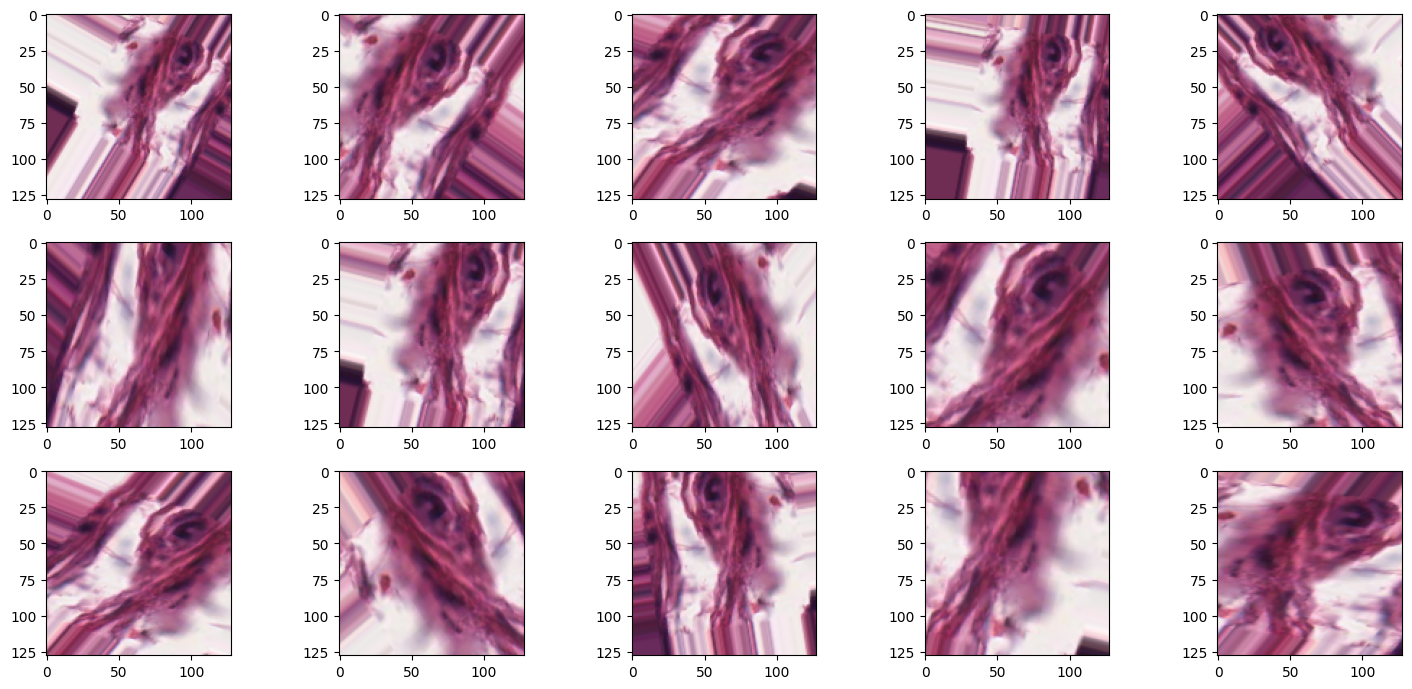

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(15)]
plotImages(augmented_images)

## Model

In [24]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(156, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        3

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
EPOCHS = 150

In [28]:
filepath = 'model_gcm3.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [29]:
history = model.fit(train_data_gen, batch_size = 32, epochs=EPOCHS, validation_data=val_data_gen,  callbacks=[checkpoint])

Epoch 1/150


2023-03-23 18:50:47.826501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 18:50:48.172341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.4107

2023-03-23 18:50:53.612838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.54800, saving model to model_gcm3.h5
94/94 [==============================] - 8s 75ms/step - loss: 1.3731 - accuracy: 0.4107 - val_loss: 0.9772 - val_accuracy: 0.5480
Epoch 2/150
94/94 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.6143
Epoch 2: val_accuracy improved from 0.54800 to 0.64500, saving model to model_gcm3.h5
94/94 [==============================] - 7s 76ms/step - loss: 0.8785 - accuracy: 0.6143 - val_loss: 0.9094 - val_accuracy: 0.6450
Epoch 3/150
94/94 [==============================] - ETA: 0s - loss: 0.8423 - accuracy: 0.6560
Epoch 3: val_accuracy improved from 0.64500 to 0.71200, saving model to model_gcm3.h5
94/94 [==============================] - 7s 75ms/step - loss: 0.8423 - accuracy: 0.6560 - val_loss: 0.7901 - val_accuracy: 0.7120
Epoch 4/150
94/94 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.6917
Epoch 4: val_accuracy did not improve from 0.71200
94/94 [===========

In [43]:
#history = model.fit(datagen.flow(x_train, y_train), batch_size = 32, epochs=EPOCHS, validation_data=datagen.flow(x_test, y_test))

In [229]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 10ms/step - loss: 1.1710 - accuracy: 0.8210


In [624]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

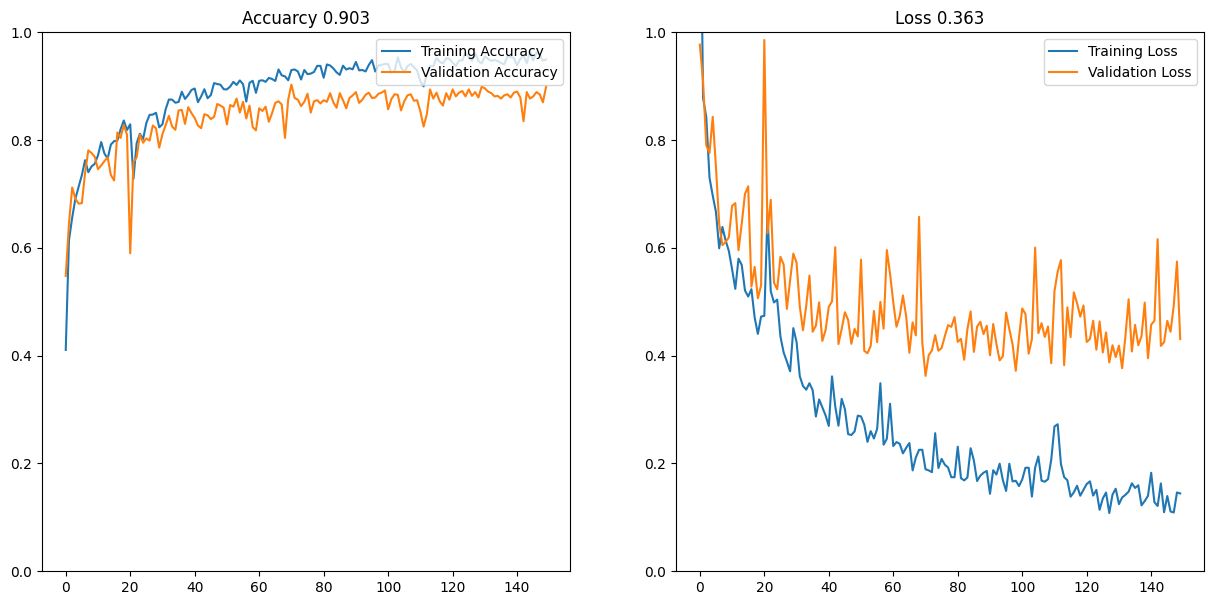

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title(f'Accuarcy {round(max(val_acc),3)}')
ax1.legend(loc='upper right')
ax1.set_ylim((0,1))

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title(f'Loss {round(min(val_loss),3)}')
ax2.legend(loc='upper right')
ax2.set_ylim((0,1))
plt.show()

In [68]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=32, verbose=0)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predIdxs, # labels transformed back to single unit
    target_names=lb.classes_))
# model.save("model_cancer_detection_cnn_v1_large", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

    01_TUMOR       0.95      0.96      0.96       104
   02_STROMA       0.94      0.79      0.86       150
  03_COMPLEX       0.77      0.77      0.77       116
   04_LYMPHO       0.85      0.95      0.90       119
   05_DEBRIS       0.86      0.91      0.89       119
   06_MUCOSA       0.92      0.95      0.93       125
  07_ADIPOSE       0.99      0.94      0.96       131
    08_EMPTY       0.96      0.99      0.97       136

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [49]:
predIdxs.shape

(1000,)

In [67]:
print(lb.classes_)

['01_TUMOR' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS' '06_MUCOSA'
 '07_ADIPOSE' '08_EMPTY']
